<a href="https://colab.research.google.com/github/aminmh/ml/blob/main/Intel_Image_Classification_(CNN_Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
#!/bin/bash
!kaggle datasets download puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 54% 187M/346M [00:00<00:00, 1.95GB/s]
100% 346M/346M [00:00<00:00, 880MB/s] 


In [ ]:
!unzip intel-image-classification.zip

In [ ]:
import os, shutil

In [ ]:
for directory in os.listdir('seg_test/seg_test'):
  shutil.move('seg_test/seg_test/' + directory, 'seg_test')

shutil.rmtree('seg_test/seg_test')

In [ ]:
for directory in os.listdir('seg_train/seg_train'):
  shutil.move('seg_train/seg_train/' + directory, 'seg_train')

shutil.rmtree('seg_train/seg_train')

In [ ]:
from glob import glob

print (f"size of training: {len(glob('seg_train/*/*.jpg'))}")
print (f"size of training: {len(glob('seg_test/*/*.jpg'))}")

size of training: 14034
size of training: 3000


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
train_dir = 'seg_train'
test_dir = 'seg_test'
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)

In [36]:
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [37]:
validation_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [39]:
print(f"all recognize classes: {train_dataset.class_names}")

all recognize classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
next(iter(train_dataset))

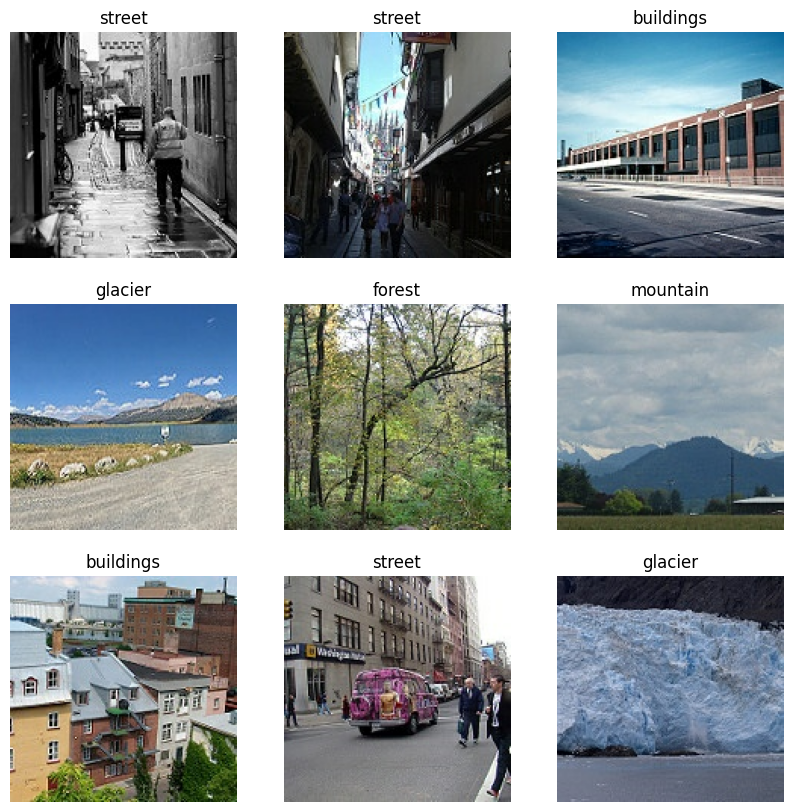

In [46]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    # Convert one-hot encoded label to integer index
    predicted_class_index = tf.argmax(labels[i]).numpy()
    plt.title(train_dataset.class_names[predicted_class_index])
    plt.axis('off')